In [1]:
def download(
    ticstr: str, 
    outdir: str = 'none'): 
    ''' 
    Args:
        outdir: directory where lightcurves will be saved. If not set, data will not be saved.  --> FIX!
        ticstr: e.g., 'TIC 441420236'.  
    Returns: 
        raw_list: list of light curve ojects that mean criteria but have not been processed (i.e. not detrended, normalized, or sigma-clipped) 
    '''
    import numpy as np 
    import lightkurve as lk 

    # get the light curve
    lcc = lk.search_lightcurve(ticstr).download_all()

    # select only the two-minute cadence SPOC-reduced data; convert to a list.
    # note that this conversion approach works for any LightCurveCollection
    # returned by lightkurve -- no need to hand-pick the right ones.  the exact
    # condition below says "if the interval is between 119 and 121 seconds,
    # take it".
    raw_list = [_l for _l in lcc
            if
            _l.meta['ORIGIN']=='NASA/Ames'
            and
            np.isclose(
                120,
                np.nanmedian(np.diff(_l.remove_outliers().time.value))*24*60*60,
                atol=1
            )
    ]

    raw_list = [_l for _l in raw_list if _l.meta['FLUX_ORIGIN']=='pdcsap_flux']

    return raw_list

raw_lc_list = download('TIC 165818534')

In [2]:
def preprocess(
    raw_list: list,
    ticstr: str = '',
    outdir: str = "none", 
    dtrdict: dict = {'method':'biweight',
                     'window_length':0.5,
                     'cval':5.0,
                     "break_tolerance":1.0}, 
    sigma_bounds: list = [10, 3]
    ):
    """
    Args:
        raw_list: raw list of light curves; see download() 
        outdir: directory where lightcurves will be saved. If not set, data will not be saved.  --> FIX!
        ticstr: e.g., 'TIC 441420236'.  
        dtrdict: dictionary with keys "window_length", "method", "cval",
                 "break_tolerance", or anything else needed by wotan's `flatten`
                 call.  These are documented at
                 https://wotan.readthedocs.io/en/latest/Usage.html 
        sigma_bounds: list of the lower and upper sigma bounds to use for post detrend sigma-clipping 
    Returns: 
        lc_list: list of light curve ojects that have met all criteria, been removed of outliers, normalized, and flattened. 
        trend_list: list of light curve objects with x = time, y = trend
        raw_list: list of the raw light curve objects 
    """

    import numpy as np 
    import lightkurve as lk 
    from wotan import flatten, slide_clip
    from astropy.stats import sigma_clip
    
    lc_list = [] # for detrended and "cleaned" light curves
    trend_list = []

    new_raw_list = []

    for lc in raw_list:

        time = lc.time.value
        flux = lc.pdcsap_flux.value
        qual = lc.quality.value

        # remove non-zero quality flags
        sel = (qual == 0)

        time = time[sel]
        flux = flux[sel]

        # normalize around 1
        flux /= np.nanmedian(flux)

        new_raw_list.append({'time':time, 'flux':flux})

        # remove outliers before local window detrending
        clipped_flux = slide_clip(time, flux, window_length=0.5, low=3,
                                  high=2, method='mad', center='median')

        # see https://wotan.readthedocs.io/en/latest/Usage.html for other
        # possible options.
        flat_flux, trend_flux = flatten(
            time, clipped_flux, return_trend=True,
            method=dtrdict['method'],
            break_tolerance=dtrdict['break_tolerance'],
            window_length=dtrdict['window_length'],
            cval=dtrdict['cval']
        )

        flat_mean, flat_sigma = (np.nanmean(flat_flux), np.nanstd(flat_flux))

        #_, *bounds = sigma_clip(flat_flux, sigma_lower=10, sigma_upper=1, maxiters=1, masked=False, return_bounds=True) # okay flex LOL

        bounds = [flat_mean-sigma_bounds[0]*flat_sigma, flat_mean+sigma_bounds[1]*flat_sigma]

        print(bounds)

        flat_mask = np.logical_and(flat_flux<bounds[1], flat_flux>bounds[0])

        flat_time = time[flat_mask]
        flat_flux = flat_flux[flat_mask]

        processed_lc = {'time':flat_time, "flux":flat_flux}
        trend_lc = {'time':time, 'flux':trend_flux}

        lc_list.append(processed_lc)
        trend_list.append(trend_lc)

    raw_list = new_raw_list 
    # return processed_list, trends_list, raw_list 

    return lc_list, trend_list, raw_list 

In [5]:
lc_list, trend_list, raw_list  = preprocess(raw_lc_list)

[0.9103399241712335, 1.02658003928561]
[0.941514554251669, 1.0175305645076593]
[0.9292672461096649, 1.021318038879817]
[0.9416433988591274, 1.0174906564687858]
[0.8761037302103283, 1.0363538755352075]


In [6]:
def plot_lightcurve(
    lc_list,
    trend_list,
    raw_list, 
    ticstr:str = '',
    outdir:str = 'none' 
): 
    """
    Args:
        ticstr: ticid, e.g. TIC 441420236
        lc_list: list of light curve objects from NASA Ames 
        lc_list: list of light curve ojects that have met all criteria, been removed of outliers, normalized, and flattened. 
        trend_list: list of light curve objects with x = time, y = trend
        raw_list: list of the raw light curve objects 
        outdir: directory into which plots should be saved. None are saved if set to default

    Returns: 

    """

    import numpy as np
    import matplotlib.pyplot as plt

    #plt.style.use('/.other/aesthetics/science.mplstyle')

    # how many sectors of 2-minute cadence TESS data (processed by the Ames
    # group) are available for this object?

    N_sectors = len(lc_list)

    fig, axs = plt.subplots(nrows=2*N_sectors, ncols=1, figsize=(12,4*N_sectors)) # share y? 

    fig.tight_layout()

    for ix in range(N_sectors):

        lc = lc_list[ix]
        trend_lc = trend_list[ix]
        raw_lc = raw_list[ix]

        # top axis: the data and model
        axs[2*ix].scatter(raw_lc['time'], raw_lc['flux'], s=1, c='black', zorder=2)
        axs[2*ix].plot(trend_lc['time'], trend_lc['flux'], lw=1, c='red',alpha=0.6, zorder=3)

        # bottom axis: the residual
        axs[2*ix+1].scatter(lc['time'], lc['flux'], s=1, c='black', zorder=2)

    if outdir=='show': 
        plt.show()
    
    elif outdir!='none': 
        plt.savefig(outdir+'/'+ticstr+'.png', bbox_inches='tight')

    plt.clf()
    #plt.close()

5


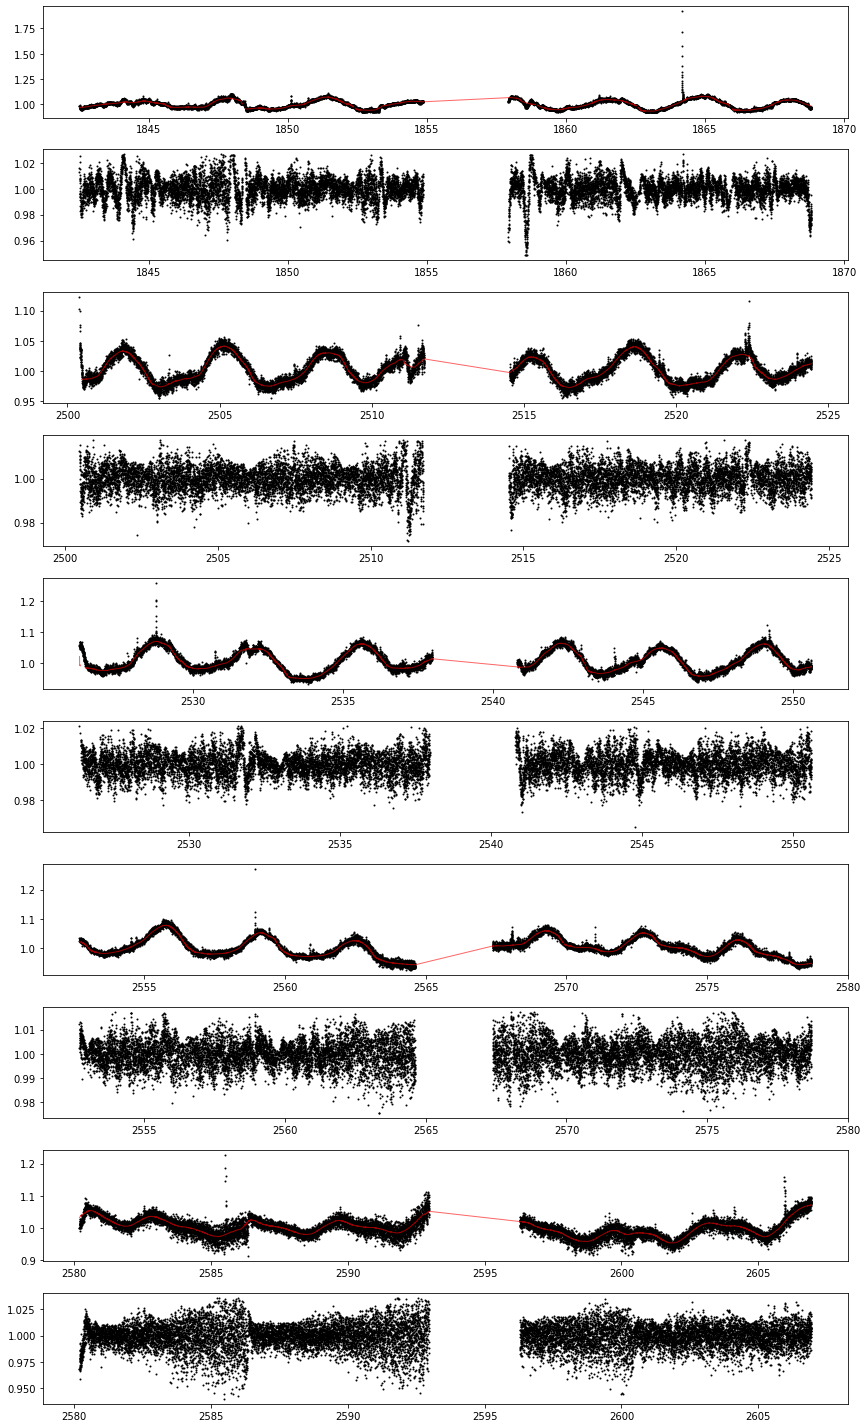

<Figure size 432x288 with 0 Axes>

In [7]:
plot_lightcurve(lc_list, trend_list, raw_list, outdir='show')

In [12]:
import lightkurve as lk
import numpy as np

times = np.array([])
fluxes = np.array([])

for i in range(len(lc_list)-1): # ignore last
    lc = lc_list[i]
    times = np.concatenate((times, lc['time']))
    fluxes = np.concatenate((fluxes, lc['flux']))

import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares

bls = BoxLeastSquares(t=times, y=fluxes)


durations = np.linspace(0.05, 0.2, 10)
periods = np.linspace(6,7,100)

results = bls.power(periods, durations, objective='snr')

6.757575757575758


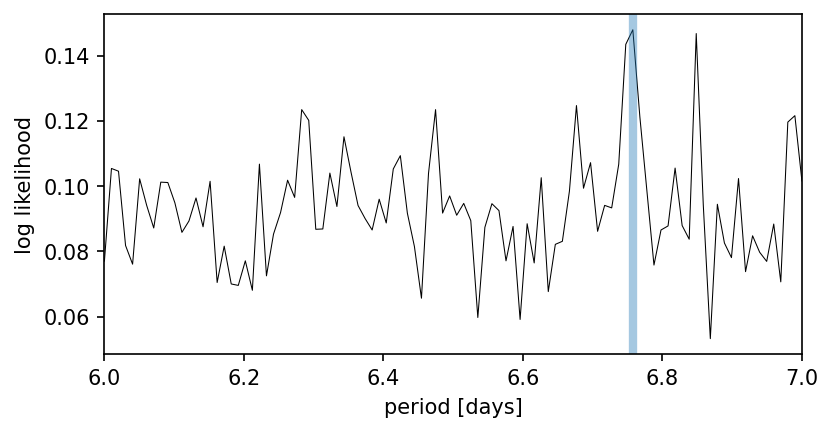

In [14]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

# Plot the periodogram
plt.rcParams["figure.dpi"] = 150
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=4)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

print(period)